## Part 1: Data Processing

### Process both time series and gamma phase-amplitude coupling (GPAC) images into dataframes

In [8]:
import numpy as np
import os
import pandas as pd
import scipy.io as sio

from IPython.display import display

In [9]:
!pip3 install matplotlib

In [15]:
!pip3 install PyWavelets
!pip3 install keras
!pip3 install tensorflow
!pip3 install sklearn

     |████████████████████████████████| 4.3 MB 3.0 MB/s eta 0:00:01


In [20]:
import matplotlib.pyplot as plt
import pywt

In [11]:
def process_timeseries_data(path):
    """ Reads and processes all time series data from MATLAB files in the provided
    path. Only relevant data will be stored for use here.
    """
    all_data = {}

    for file_name in os.listdir(path):
        # 'data' will contain all relevant data that should be used for training.
        # Other keys will hold other useful information that shouldn't be directly
        # needed for training.
        data = {'data': {}}
        
        full_file_path = os.path.join(path, file_name)
        mat_data = sio.loadmat(full_file_path)

        # Time series data with size equal to the number of channels (i.e. electrodes).
        # The electrode names can be indexed to find the electrode that a specific
        # value in this time series data belongs to.
        data['data']['samples'] = list(np.swapaxes(np.array(mat_data['Data']), 0, 1))

        # Time points in seconds
        data['data']['time'] = np.array(mat_data['Time'][0])

        data['data'] = pd.DataFrame(data['data'])
        
        # List of electrode names following the 10-20 EEG recording system
        data['electrodes'] = np.array([item.item() for item in mat_data['Electrodes'][0]])

        all_data[full_file_path] = data

    return all_data


def process_gpac_image_data(path):
    """ Reads and processes all GPAC image data from MATLAB files in the provided
    path. Only relevant data will be stored for use here.
    """
    all_data = {}

    for file_name in os.listdir(path):
        # 'data' will contain all relevant data that should be used for training.
        # Other keys will hold other useful information that shouldn't be directly
        # needed for training.
        data = {'data': {}}
        
        full_file_path = os.path.join(path, file_name)
        mat_data = sio.loadmat(full_file_path)

        # Sample point number corresponding to the start of each 2s window
        data['data']['window_start'] = np.array(mat_data['data']['wind'][0][0][0])

        # GPAC data of size lf x hf, where lf and hf are the dimensions of the GPAC image
        # Note that each window has its data flattened to one list of size lf x hf. We need
        # to cast the reshaped data as a list so that, for this column, each row contains a
        # list of the lf x hf data.
        data['data']['fv'] = np.array(mat_data['data']['fv'][0][0])
        #data['data']['fv'] = list(data['data']['fv'].reshape(data['data']['fv'].shape[0], -1))

        # Window labels: baseline interictal (0), blink (1), movement (2), or EMG (3). -1
        # means the window wasn't labelled.
        data['data']['label'] = np.squeeze(np.array(mat_data['training_labels']), axis=1)

        #data['data'] = pd.DataFrame(data['data'])

        # The duration of the window chosen for analysis, which should always be 2s
        data['window_len'] = np.array(mat_data['ws'][0])
        
        # lf and hf are the frequency values corresponding to the phase range and amplitude
        # range of interest in the GPAC feature, respectively.
        data['lf'] = np.array(mat_data['lf'][0])
        data['hf'] = np.array(mat_data['hf'][0])

        all_data[full_file_path] = data

    return all_data

In [12]:
# Read all relevant data from the MATLAB files
BASE_DATA_PATH = "data"
TIME_SERIES_DATA_PATH = os.path.join(BASE_DATA_PATH, "TimeSeries")
GPAC_IMAGES_DATA_PATH = os.path.join(BASE_DATA_PATH, "GPAC_Images_Labelled")

timeseries_data = process_timeseries_data(TIME_SERIES_DATA_PATH)
gpac_image_data = process_gpac_image_data(GPAC_IMAGES_DATA_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'data/TimeSeries'

In [4]:
test_file = 'data_AL_D6_2_1_export.mat'
test_gpac_data = gpac_image_data[os.path.join(GPAC_IMAGES_DATA_PATH, test_file)]
test_timeseries_data = timeseries_data[os.path.join(TIME_SERIES_DATA_PATH, test_file)]

# Time series data
print("---------- TIME SERIES DATA FORMAT ----------")

print("\n\nData For Training:")
display(test_timeseries_data['data'])

print("\n\nElectrode Names:")
display(test_timeseries_data['electrodes'])

print(f"\n\nNumber of Channels Per Sample: {len(test_timeseries_data['data']['samples'][0])}")


# GPAC image data
print("\n\n\n---------- GPAC IMAGE DATA FORMAT ----------")

print("\n\nData For Training:")
display(test_gpac_data['data'])

print(f"\n\nWindow Length (seconds): {test_gpac_data['window_len'].item()}")

print("\n\nPhase Range Of Interest:")
display(test_gpac_data['lf'])

print("\n\nAmplitude Range Of Interest:")
display(test_gpac_data['hf'])

print(f"\n\nNumber of Datapoints Per GPAC Image: {len(test_gpac_data['data']['fv'][0])}")


---------- TIME SERIES DATA FORMAT ----------


Data For Training:


,samples,time
0,"[6.108219724308253e-05, 4.1935847751014113e-05...",0.000
1,"[6.0519399017154524e-05, 4.2618500927900726e-0...",0.002
2,"[6.742417259467301e-05, 4.1556992611811064e-05...",0.004
3,"[5.537121535626189e-05, 4.2360979111764424e-05...",0.006
4,"[5.912841684511108e-05, 4.846190553369728e-05,...",0.008
...,...,...
949494,"[-3.11911321717285e-05, 2.3324337114086137e-05...",1898.988
949495,"[-2.9876694427662773e-05, 2.2369713074451038e-...",1898.990
949496,"[-3.09238426711861e-05, 2.1764404072353062e-05...",1898.992
949497,"[-3.018560838381861e-05, 1.9767057467827266e-0...",1898.994




Electrode Names:


array(['FP1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'F9', 'T9', 'P9',
       'Fz', 'Cz', 'Pz', 'FP2', 'F8', 'T4', 'T6', 'O2', 'F4', 'C4', 'P4',
       'F10', 'T10', 'P10'], dtype='<U3')



Number of Channels Per Sample: 25



---------- GPAC IMAGE DATA FORMAT ----------


Data For Training:


,window_start,fv,label
0,1436.0,"[0.025656345787360417, 0.032179734517346216, 0...",0
1,2436.0,"[0.025213492886223276, 0.025289140962647953, 0...",3
2,3436.0,"[0.023487781808931615, 0.01826561582104771, 0....",1
3,4436.0,"[0.06850261987711749, 0.07487524108974554, 0.0...",2
4,5436.0,"[0.028818125484047188, 0.02471954469685771, 0....",0
...,...,...,...
941,942436.0,"[0.02258746497266887, 0.018580595931532815, 0....",-1
942,943436.0,"[0.03575053160503277, 0.03564018155802227, 0.0...",-1
943,944436.0,"[0.030996596628728112, 0.028858710017469907, 0...",-1
944,945436.0,"[0.030891367009021852, 0.030663095755187705, 0...",-1




Window Length (seconds): 2


Phase Range Of Interest:


array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. ])



Amplitude Range Of Interest:


array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150])



Number of Datapoints Per GPAC Image: 11921


In [5]:
def label_time_series(time_series, GPAC_series):
    """
    Fucntion that will translate the labels from the GPAC Dataframe to the Time-Series DataFrame 
    """
    
    # Initial label value for all rows in the time_series
    time_series['data']['label'] = -1
    
    # Iterate through the GPAC rows to obtain the window value and the label 
    for index, row in GPAC_series['data'].iterrows():
        window_start = int(row['window_start'])
        label_value = row['label']
        
        # Set the 'label' value for the time series Dataframe
        # Add 1000 to window_start because in time_series it is separated by intervals of 0.002 s.
        # 1 window size = 2s, 2 / 0.002 = 1000 rows 
        time_series['data'].loc[window_start : window_start+1000, 'label'] = label_value
    
    return time_series
    
test_timeseries_data_labelled = label_time_series(test_timeseries_data, test_gpac_data)

print("\n\nAs seen in the GPAC Dataframe in the previous cell, the label begins at t=1436, and below you can see that change:")
display(test_timeseries_data_labelled['data'].iloc[1433:1439])

print("\n\nSimilarly, the second label begins at t=2436, and below you can see that change:")
display(test_timeseries_data_labelled['data'].iloc[2433:2439])

print("\n\nLabel value statistics of the time-series data:")
print(test_timeseries_data_labelled['data']['label'].value_counts())

print("\n\nLabel value statistics of the GPAC data:")
print(test_gpac_data['data']['label'].value_counts())



As seen in the GPAC Dataframe in the previous cell, the label begins at t=1436, and below you can see that change:


,samples,time,label
1433,"[-3.918726818570923e-05, 3.1590051061025356e-0...",2.866,-1
1434,"[-2.7482217912228493e-05, 3.294411591614816e-0...",2.868,-1
1435,"[-3.871242545568842e-05, 3.251909070927831e-05...",2.870,-1
1436,"[-4.014147248365788e-05, 3.043857439682265e-05...",2.872,0
1437,"[-3.478690402970244e-05, 3.202987604497138e-05...",2.874,0
1438,"[-3.337380150125322e-05, 3.7954873986926406e-0...",2.876,0




Similarly, the second label begins at t=2436, and below you can see that change:


,samples,time,label
2433,"[6.336374464748228e-05, 6.706071296848414e-05,...",4.866,0
2434,"[5.307997547277073e-05, 6.623601097400111e-05,...",4.868,0
2435,"[5.416560886950276e-05, 6.953586163041345e-05,...",4.870,0
2436,"[6.708489008597993e-05, 7.019486785538814e-05,...",4.872,3
2437,"[7.915946937218587e-05, 7.136690139654629e-05,...",4.874,3
2438,"[7.392872574665033e-05, 7.387425424376896e-05,...",4.876,3




Label value statistics of the time-series data:
-1    889499
 3     15000
 2     15000
 1     15000
 0     15000
Name: label, dtype: int64


Label value statistics of the GPAC data:
-1    886
 3     15
 2     15
 1     15
 0     15
Name: label, dtype: int64


## Part 2: Data Transform

In [21]:
import numpy as np
import pywt
import scipy

def do_cwt(X,freq,fs,wavename = 'cmor5-0.8125'):
    """Computes complex wavelet transform for EEG data

    Parameters
    ----------
    X : input data
    freq : input frequency range eg. 0.25:0.25:50
    fs : sampling frequency
    wavename : The default is 'cmor5-0.8125'.

    Returns
    -------
    cwt complex coefficients
    frequency range
    time
    """
    T = 1.0/fs
    t = np.arange(0,len(X)*T,T)
    a_coef = pywt.centrfrq(wavename)* (1.0/(freq*T))
    
    # calculate the wavelet coefficients (distance x frequency x time)
    cwt_c = pywt.cwt(X,a_coef,wavename, method='fft')
    return cwt_c[0], freq, t

def get_all_cwts(X, lf, hf, fs, wavename='cmor5-0.8125'):
    n_samples, n_channels = X.shape
    rCWT_lf = np.zeros((n_channels, np.size(lf), n_samples), dtype=complex)
    rCWT_hf = np.zeros((n_channels, np.size(hf), n_samples), dtype=complex)

    for signal in range(n_channels):
        data_compute = X[:, signal]
        rCWT_lf[signal, :, :], _, _ = do_cwt(data_compute, lf, fs, 'cmor6-0.8125')
        rCWT_hf[signal, :, :], _, _ = do_cwt(data_compute, hf, fs, 'cmor6-0.8125')
    
    return rCWT_lf, rCWT_hf

def do_cwt_scipy(X, freq, fs, w=0.8125):
    """Computes complex wavelet transform for EEG data

    Parameters
    ----------
    X : input data
    freq : input frequency range eg. 0.25:0.25:50
    fs : sampling frequency
    wavename : The default is 'cmor5-0.8125'.

    Returns
    -------
    cwt complex coefficients
    frequency range
    time
    """
    T = 1.0/fs
    t = np.arange(0,len(X)*T,T)
    widths = w*fs / (2*freq*np.pi)

    # calculate the wavelet coefficients (distance x frequency x time)
    print(scipy.__version__)
    cwt_c = scipy.signal.cwt(X, scipy.signal.morlet2, widths, dtype=np.complex128, w=w)
    return cwt_c, freq, t

def do_tort_pac(c1,c2,N=18):
    """Computes phase-amplitude coupling index based on Tort's algorithm

    Parameters
    ----------
    c1 : cwt coefficients for phase frequencies
    c2 : cwt coefficients for amplitude frequencies
    N : number of phase bins

    Returns
    -------
    PAC - Phase-Amplitude Coupling Index.

    """
    nphase = c1.shape[0]
    namplitude = c2.shape[0]
    amp = np.abs(c2)
    phi = np.arctan2(np.imag(c1),np.real(c1)) + np.pi
    PAC=np.empty([namplitude,nphase])
    # for idx1 in tqdm(np.arange(nphase)): # TQDM slows down code
    for idx1 in np.arange(nphase):
        for idx2 in np.arange(namplitude):
            phase = phi[idx1,:]
            amplitude = amp[idx2,:]
            rng = 2*np.pi/N
            Afa = np.zeros([N,1])
            for idx3 in np.arange(N):
                ST = (idx3)*rng
                ET = (idx3+1)*rng
                Afa[idx3] = np.mean(amplitude[np.argwhere(np.logical_and(phase>ST, phase<=ET)==True)])
            p = Afa/np.sum(Afa)
            H = -np.sum(p*np.log(p))
            PAC[idx2,idx1] = (np.log(N) - H)/np.log(N)
    PAC.shape
    PAC[np.isnan(PAC)] = 1
    return PAC


def do_tort_pac_gpu_cupy_complete_vectorized(c1,c2,N=18):
    """
    Computes PAC coupling index using CuPy

    Parameters
    ----------
    c1 : cwt coefficients for phase frequencies, num_channels x num_phase x num_samples
    c2 : cwt coefficients for amplitude frequencies, num_channels x num_amps x num_samples
    N : number of phase bins

    Returns
    -------
    PAC - Phase-Amplitude Coupling Index of all channels
    """

    c1 = cp.asarray(c1)
    c2 = cp.asarray(c2)
    bin_ranges = cp.linspace(0, 2*cp.pi, N + 1)
    n_signals = c1.shape[0] # Number of channels
    n_samples = c1.shape[2] # Length of signal
    n_phases = c1.shape[1] # Number of frequencies of phase signal
    n_amps = c2.shape[1] # Number of frequencies of amplitude signal

    # Compute phases and amplitudes of coefficients
    phase_values = np.tile(cp.angle(c1) + cp.pi, (N, 1, 1, 1)) # num_channels x num_phase x num_samples x N
    amp_values = np.tile(cp.absolute(c2), (N, 1, 1, 1)) # num_channels x num_amps x num_samples x N
    bin_range_1 = bin_ranges[:-1].reshape(N, 1, 1, 1) # Left side of ranges
    bin_range_2 = bin_ranges[1:].reshape(N, 1, 1, 1) # Right side of ranges

    # Bin amplitudes based on phase
    all_phase_amps = cp.zeros((N, n_signals, n_phases, n_amps)) # num_channels x num_bins x num_phases x num_amps
    curr_value = cp.zeros((N, n_signals, n_phases, n_samples)) # Hold binary values of whether phases is in bins, num_channels x num_phase x num_samples
    curr_value[(phase_values > bin_range_1) & (phase_values < bin_range_2)] = 1
    all_phase_amps = cp.einsum('ijkl,ijlm->ijkm', curr_value, cp.transpose(amp_values, (0, 1, 3, 2)))

    # Calculate modulation indices
    PAC = cp.zeros((n_signals, n_phases, n_amps))
    all_phase_amps = all_phase_amps / cp.sum(all_phase_amps, 0).reshape(1, n_signals, n_phases, n_amps)
    all_entropies = -cp.sum(all_phase_amps * cp.log(all_phase_amps), 0) # num_channels x num_phase x num_samples
    all_entropies[cp.isnan(all_entropies)] = 0
    PAC = (cp.log(N) - all_entropies) / cp.log(N)

    return cp.asnumpy(PAC)

def do_tort_pac_numpy(c1,c2,N=18):
    """
    Computes PAC coupling index using Numpy

    Parameters
    ----------
    c1 : cwt coefficients for phase frequencies, num_channels x num_phase x num_samples
    c2 : cwt coefficients for amplitude frequencies, num_channels x num_amps x num_samples
    N : number of phase bins

    Returns
    -------
    PAC - Phase-Amplitude Coupling Index of all channels
    """
    bin_ranges = np.linspace(0, 2*np.pi, N + 1)
    n_signals = c1.shape[0] # Number of channels
    n_samples = c1.shape[2] # Length of signal
    n_phases = c1.shape[1] # Number of frequencies of phase signal
    n_amps = c2.shape[1] # Number of frequencies of amplitude signal

    # Compute phases and amplitudes of coefficients
    phase_value = np.angle(c1) + np.pi # num_channels x num_phase x num_samples
    amp_values = np.absolute(c2) # num_channels x num_amps x num_samples

    # Bin amplitudes based on phase
    all_phase_amps = np.zeros((n_signals, n_phases, n_amps, N)) # num_channels x num_phases x num_amps x num_bins
    for b in range(N): # Iterate through each bin
        # Hold binary values of whether a phase in in the current bin, num_channels x num_phase x num_samples
        curr_value = np.zeros((n_signals, n_phases, n_samples))
        curr_value[(phase_value > bin_ranges[b]) & (phase_value < bin_ranges[b + 1])] = 1
        all_phase_amps[..., b] = np.einsum('ijk,ikl->ijl', curr_value, np.transpose(amp_values, (0, 2, 1)))

    # Calculate modulation indices
    PAC = np.zeros((n_signals, n_phases, n_amps))
    all_phase_amps = all_phase_amps / np.sum(all_phase_amps, 3).reshape(n_signals, n_phases, n_amps, 1)
    all_entropies = -np.sum(all_phase_amps * np.log(all_phase_amps), 3) # num_channels x num_phase x num_samples
    all_entropies[np.isnan(all_entropies)] = 0
    PAC = (np.log(N) - all_entropies) / np.log(N)

    return PAC

#print(f'Time elapsed: {((time.time()-t)/60)} mins.')

In [24]:
def generateTrainingImages(gpacData):
    """ Reads and processes all GPAC data from previous preprocessing and convert the data
    into images in greyscale and in a heatmap.
    """
    plt.axis('off')
    for file in gpacData.keys():
        for i, gpac in enumerate(gpacData[file]['data']['fv']):
            label = gpacData[file]['data']['label'][i]
            # Window labels: baseline interictal (0), blink (1), movement (2), or EMG (3). -1
            if label != -1:
                if label == 0:
                    folder = 'Baseline'
                elif label == 1:
                    folder = 'Blink'
                elif label == 2:
                    folder = 'Movement'
                else:
                    folder = 'EMG'
                #saves all of the images in a heatmap
                plt.imshow(gpac)
                plt.savefig('data/images/' + folder  + '/' + file.split('/')[2] + str(i) + '.png', bbox_inches='tight', pad_inches=0)
                plt.imshow(gpac, cmap='gray')
                plt.savefig('data/greyscaleimages/' + folder  + '/' + file.split('/')[2] + str(i) + '.png', bbox_inches='tight', pad_inches=0)

generateTrainingImages(process_gpac_image_data("data/GPAC_Images_Labelled/"))

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x12a97cb90> (for post_execute):


KeyboardInterrupt: 

In [6]:
def split_gpac_data(gpac_image_data):
    """
    Function that takes all of the data, filters out the rows w/ a label of -1, and then splits 
    the data into Training, Validation, and Test 
    """
    
    all_data = pd.DataFrame(data=None, columns=['fv', 'label'])
    for data_file in gpac_image_data:
        
        # Isolate the image data portion of each dataset
        sub_data = gpac_image_data[data_file]['data']
        sub_data = sub_data.drop(['window_start'], axis=1)
        
        # Now we need to filter out the rows where the 'label' value is -1
        all_data = all_data.append(sub_data[sub_data['label'] > -1])
 
    # Now is the splitting of the dataframe into train, test, and validation datafames
    train_data, valid_data, test_data = np.split(all_data.sample(frac=1, random_state=42),
                                                [int(0.7 * len(all_data)), int(0.85 * len(all_data))])

    return train_data, valid_data, test_data

train_GPAC_data, valid_GPAC_data, test_GPAC_data = split_gpac_data(gpac_image_data)

print('\n\n\nTraining DataFrame and class breakdown')
display(train_GPAC_data)
print(train_GPAC_data['label'].value_counts())

print('\n\n\nValidation DataFrame and class breakdown')
display(valid_GPAC_data)
print(valid_GPAC_data['label'].value_counts())


print('\n\n\nTesting DataFrame and class breakdown')
display(test_GPAC_data)
print(test_GPAC_data['label'].value_counts())




Training DataFrame and class breakdown


,fv,label
29,"[0.026578952832569915, 0.026412519206571176, 0...",0
78,"[0.02800487592515676, 0.029052029221901535, 0....",1
55,"[0.025124325652987813, 0.031375009659407566, 0...",3
47,"[0.020210080472589032, 0.022508189853962215, 0...",1
122,"[0.030996552869302977, 0.026865984990070035, 0...",0
...,...,...
308,"[0.010803333963981525, 0.0118814992139812, 0.0...",3
64,"[0.031236079506050358, 0.031084527056174267, 0...",2
117,"[0.014191182648672597, 0.015199027755557856, 0...",0
16,"[0.020171488917380204, 0.024004959061443593, 0...",0


1    190
2    183
0    181
3    159
Name: label, dtype: int64



Validation DataFrame and class breakdown


,fv,label
52,"[0.014733216292781329, 0.017871067660787204, 0...",0
415,"[0.01539657580177166, 0.01762881651874175, 0.0...",1
147,"[0.01697825458691218, 0.021063065301587837, 0....",2
830,"[0.029521058016560575, 0.028428084263004413, 0...",2
57,"[0.02071872802952908, 0.023718854449010056, 0....",0
...,...,...
300,"[0.023846782348386927, 0.023604339849121175, 0...",2
80,"[0.022091000048192377, 0.02198952428966747, 0....",0
32,"[0.02298728062890155, 0.022495106975133423, 0....",1
9,"[0.02018893758579846, 0.016546600276505345, 0....",0


3    43
2    39
0    36
1    35
Name: label, dtype: int64



Testing DataFrame and class breakdown


,fv,label
51,"[0.014029436354815213, 0.014280474969277254, 0...",0
370,"[0.03026395156144915, 0.030441104676146632, 0....",1
456,"[0.018051205585293762, 0.020033789914877715, 0...",2
102,"[0.025893012259715704, 0.021900611378626946, 0...",0
36,"[0.019407836535601047, 0.0187561280211469, 0.0...",0
...,...,...
8,"[0.02746254970056796, 0.022406735048318086, 0....",0
107,"[0.02350585332112601, 0.025473906998611087, 0....",2
490,"[0.02423272928835719, 0.02342685552305181, 0.0...",2
28,"[0.015755475703704988, 0.01818003315805917, 0....",3


3    53
0    37
2    33
1    30
Name: label, dtype: int64


## Part 3: ML Input-Output Preprocessing

In [104]:
data = []
labels = []

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img



directory = 'data/images/Baseline'
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        img = img_to_array(load_img(os.path.join(directory, filename)))
        data.append(img)
        y=0
        labels.append(y)
    else:
        continue

directory = 'data/images/Blink'
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        img = img_to_array(load_img(os.path.join(directory, filename)))
        data.append(img)
        y=1
        labels.append(y)
    else:
        continue

directory = 'data/images/Movement'
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        img = img_to_array(load_img(os.path.join(directory, filename)))
        data.append(img)
        y=2
        labels.append(y)
    else:
        continue        

directory = 'data/images/EMG'
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        img = img_to_array(load_img(os.path.join(directory, filename)))
        data.append(img)
        y=3
        labels.append(y)
    else:
        continue

In [105]:
print(labels[-5:])
print(data[0])


[3, 3, 3, 3, 3]
[[[119. 208.  82.]
  [126. 210.  78.]
  [197. 223.  33.]
  ...
  [ 54.  90. 140.]
  [ 54.  90. 140.]
  [ 55.  88. 140.]]

 [[139. 213.  70.]
  [141. 214.  68.]
  [205. 224.  29.]
  ...
  [ 48. 104. 141.]
  [ 48. 104. 141.]
  [ 48. 104. 141.]]

 [[151. 216.  62.]
  [157. 217.  58.]
  [207. 225.  28.]
  ...
  [ 43. 115. 142.]
  [ 43. 116. 142.]
  [ 43. 116. 142.]]

 ...

 [[ 68.   3.  87.]
  [ 68.   3.  87.]
  [ 68.   3.  87.]
  ...
  [ 72.  26. 108.]
  [ 72.  26. 108.]
  [ 72.  26. 108.]]

 [[ 68.   3.  87.]
  [ 68.   3.  87.]
  [ 68.   3.  87.]
  ...
  [ 72.  25. 107.]
  [ 72.  25. 107.]
  [ 72.  25. 107.]]

 [[ 68.   3.  87.]
  [ 68.   3.  87.]
  [ 68.   3.  87.]
  ...
  [ 72.  25. 107.]
  [ 72.  25. 107.]
  [ 72.  25. 107.]]]


In [106]:
df = pd.DataFrame(list(zip(data, labels)), 
               columns =['data', 'labels']) 
df

,data,labels
0,"[[[119.0, 208.0, 82.0], [126.0, 210.0, 78.0], ...",0
1,"[[[105.0, 204.0, 91.0], [105.0, 204.0, 91.0], ...",0
2,"[[[114.0, 207.0, 85.0], [109.0, 206.0, 88.0], ...",0
3,"[[[167.0, 219.0, 51.0], [165.0, 218.0, 53.0], ...",0
4,"[[[250.0, 230.0, 34.0], [250.0, 230.0, 34.0], ...",0
...,...,...
469,"[[[34.0, 167.0, 132.0], [34.0, 167.0, 132.0], ...",3
470,"[[[50.0, 99.0, 141.0], [49.0, 100.0, 141.0], [...",3
471,"[[[35.0, 135.0, 141.0], [36.0, 133.0, 141.0], ...",3
472,"[[[59.0, 186.0, 117.0], [62.0, 188.0, 115.0], ...",3


In [107]:
df = df.sample(frac=1).reset_index(drop=True)

## Part 4: ML Model (Baseline)

In [134]:
# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

# to calculate accuracy
from sklearn.metrics import accuracy_score

X = data
y = labels

from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)


X_train = X[:int(len(X)*0.7)]
X_test = X[int(len(X)*0.7):]

y_train = y[:int(len(X)*0.7)]
y_test = y[int(len(X)*0.7):]

print(y_train[0])
print(X_train[0].shape)

X_train = np.array(X_train).reshape(len(X_train), 313, 217, 3)
X_test = np.array(X_test).reshape(len(X_test), 313, 217, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = np.array(y_train)
y_test = np.array(y_test)


# one-hot encoding using keras' numpy-related utilities
n_classes = 4
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(313,217,3)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(4, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_test, Y_test))


0
(217, 313, 3)
Shape before one-hot encoding:  (331,)
Shape after one-hot encoding:  (331, 4)
Epoch 1/20
3/3 [==============================] - 28s 9s/step - loss: 12482.7266 - accuracy: 0.2719 - val_loss: 21511.0566 - val_accuracy: 0.2308
Epoch 2/20
3/3 [==============================] - 35s 12s/step - loss: 15432.1240 - accuracy: 0.2326 - val_loss: 7424.7300 - val_accuracy: 0.2657
Epoch 3/20
3/3 [==============================] - 15s 5s/step - loss: 4703.5942 - accuracy: 0.2085 - val_loss: 1634.2939 - val_accuracy: 0.2727
Epoch 4/20
3/3 [==============================] - 10s 3s/step - loss: 1912.9373 - accuracy: 0.2024 - val_loss: 1123.0190 - val_accuracy: 0.2378
Epoch 5/20
3/3 [==============================] - 9s 3s/step - loss: 1472.7590 - accuracy: 0.2810 - val_loss: 1174.0292 - val_accuracy: 0.2797
Epoch 6/20
3/3 [==============================] - 13s 4s/step - loss: 982.6077 - accuracy: 0.2568 - val_loss: 692.8527 - val_accuracy: 0.2378
Epoch 7/20
3/3 [========================

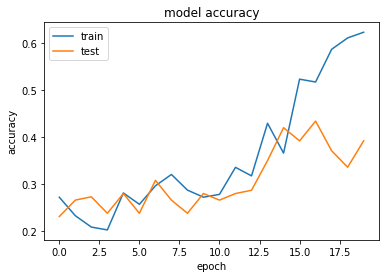

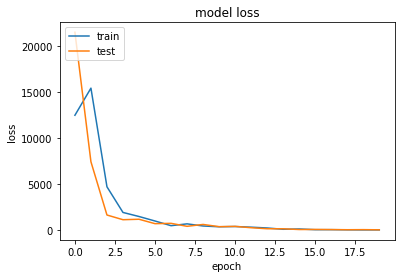

In [135]:

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()